# Analysis WeRateDogs Twitter Data

In [77]:
#Import needed modules
from datetime import datetime as dt
from matplotlib import dates as mpl_dates
import matplotlib.pyplot as plt
from io import BytesIO
from PIL import Image
import seaborn as sns
import pandas as pd
import numpy as np
import requests
import tweepy
import json
import os
import re

## 1. Wrangling Data
## 1.1 Gathering
 This is the first step of wrangling data, at which 3 different data sources will be used to collect 3 different file formats. Then import each into a Pandas dataframe to assess in the next step.

### First source

In [2]:
#Import a manually downloaded CSV file into a dataframe
archive_df = pd.read_csv('twitter-archive-enhanced.csv')

Check if the `archive_df` has been successfully added

In [3]:
archive_df.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


### Second source

In [3]:
# Download a TSV file and accessing its content using requests library
url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
file_name = url.split('/')[-1]
response = requests.get(url)

if not os.path.isfile(file_name):
    with open(file_name, 'wb') as f:
        f.write(response.content)

# Import the file into a dataframe
image_prediction_df = pd.read_csv(file_name, sep='\t')

Check if the `image_prediction_df` has been successfully added

In [5]:
image_prediction_df.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


### Third source

In [4]:
# Create the API object
api_key = 'XUl2Qi5tHMstFqX0uDrOPcYqc'
api_secret = 'tpSzYKUqoMeGTAU9aqAveuvnbdOouKjQNS6FskEF7qcs4qZnHG'
access_token = '1290104142845935616-HiSggyPGxlgICVnA7ezIrxsOU7OxiJ'
access_secret = 'rmn96KhX2p4xaKAmKH4SAxtdiDxIUvDwAH81tzcrtejNx'

auth = tweepy.OAuthHandler(api_key, api_secret)
auth.set_access_token(access_token, access_secret)

api = tweepy.API(auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)

# Create the JSON file taking into consideration the errors that
# May occur due to deleted tweets or other reasons.
errors = []

if not os.path.isfile('tweet_json.txt'):
    with open ('tweet_json.txt', 'w') as f:
        for tweet_id in archive_df['tweet_id']:
            try:
                status = api.get_status(tweet_id, wait_on_rate_limit=True,  wait_on_rate_limit_notify=True, tweet_mode = 'extended')
                json.dump(status._json, f)
                file.write('\n')
            except Exception as e:
                print("Error on tweet id {}".format(tweet_id) + ";" + str(e))
                errors.append(tweet_id)


In [5]:
# Create an empty list, in which add each line (tweet)
# of the JSON file as a dictionary.
api_list = []

with open('tweet_json.txt') as f:
    for line in f:
        tweet = json.loads(line)
        api_list.append(tweet)

# Import the JSON file into a dataframe
api_df = pd.DataFrame(api_list)
# Keep only the attributes we need in the analysis
api_df = api_df[[ 'id' , 'retweet_count' , 'favorite_count']]

Check if the `api_df` has been successfully added

In [8]:
api_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2331 entries, 0 to 2330
Data columns (total 3 columns):
id                2331 non-null int64
retweet_count     2331 non-null int64
favorite_count    2331 non-null int64
dtypes: int64(3)
memory usage: 54.7 KB


________________________________________________________________________________________________________________
## 1.2 Assessing
 This is the second step of wrangling data where the inspection of our collected data sets from both the Quality and Tidiness perspectives will be conducted.

### 1.2.1 Visual Assessment

In [9]:
archive_df

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None
5,891087950875897856,NaN,NaN,2017-07-29 00:08:17 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a majestic great white breaching ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891087950...,13,10,None,None,None,None,None
6,890971913173991426,NaN,NaN,2017-07-28 16:27:12 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Jax. He enjoys ice cream so much he gets ...,NaN,NaN,NaN,"https://gofundme.com/ydvmve-surgery-for-jax,ht...",13,10,Jax,None,None,None,None
7,890729181411237888,NaN,NaN,2017-07-28 00:22:40 +0000,"<a href=""http://twitter.com/download/iphone"" r...",When you watch your owner call another dog a g...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890729181...,13,10,None,None,None,None,None
8,890609185150312448,NaN,NaN,2017-07-27 16:25:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Zoey. She doesn't want to be one of th...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890609185...,13,10,Zoey,None,None,None,None
9,890240255349198849,NaN,NaN,2017-07-26 15:59:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Cassie. She is a college pup. Studying...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890240255...,14,10,Cassie,doggo,None,None,None


In [10]:
archive_df.text

0       This is Phineas. He's a mystical boy. Only eve...
1       This is Tilly. She's just checking pup on you....
2       This is Archie. He is a rare Norwegian Pouncin...
3       This is Darla. She commenced a snooze mid meal...
4       This is Franklin. He would like you to stop ca...
5       Here we have a majestic great white breaching ...
6       Meet Jax. He enjoys ice cream so much he gets ...
7       When you watch your owner call another dog a g...
8       This is Zoey. She doesn't want to be one of th...
9       This is Cassie. She is a college pup. Studying...
10      This is Koda. He is a South Australian decksha...
11      This is Bruno. He is a service shark. Only get...
12      Here's a puppo that seems to be on the fence a...
13      This is Ted. He does his best. Sometimes that'...
14      This is Stuart. He's sporting his favorite fan...
15      This is Oliver. You're witnessing one of his m...
16      This is Jim. He found a fren. Taught him how t...
17      This i

##### Quality:
- Missing values (`in_reply_to_status_id`, `in_reply_to_user_id`, `retweeted_status_id`, `retweeted_status_user_id`, `retweeted_status_timestamp`)
- No need for retweets or replies data (`retweeted_status_id`, `retweeted_status_user_id`, `retweeted_status_timestamp`, `in_reply_to_status_id`, `in_reply_to_user_id`)
- Missing values stored as `None` (`name`, `doggo`, `floofer`, `pupper`, `puppo`) *** are they retrievable?
- Obscure column names ( all columns except for `tweet_id`)
- Some observations at `name` column are inaccurate (example: such, a)
- Some observations at `rating_numerator` are bizarre.. worth taking a look at. (example: 2)

##### Tidiness:
- The columns `doggo`, `floofer`, `pupper` and `puppo` should be combined into one attribute `dog_stage`, since they're different value representations of the same variable.
- Add gender table? It's clear that dogs take gender pronouns in the tweet `text` column.

In [11]:
image_prediction_df

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True
5,666050758794694657,https://pbs.twimg.com/media/CT5Jof1WUAEuVxN.jpg,1,Bernese_mountain_dog,0.651137,True,English_springer,0.263788,True,Greater_Swiss_Mountain_dog,0.016199,True
6,666051853826850816,https://pbs.twimg.com/media/CT5KoJ1WoAAJash.jpg,1,box_turtle,0.933012,False,mud_turtle,0.045885,False,terrapin,0.017885,False
7,666055525042405380,https://pbs.twimg.com/media/CT5N9tpXIAAifs1.jpg,1,chow,0.692517,True,Tibetan_mastiff,0.058279,True,fur_coat,0.054449,False
8,666057090499244032,https://pbs.twimg.com/media/CT5PY90WoAAQGLo.jpg,1,shopping_cart,0.962465,False,shopping_basket,0.014594,False,golden_retriever,0.007959,True
9,666058600524156928,https://pbs.twimg.com/media/CT5Qw94XAAA_2dP.jpg,1,miniature_poodle,0.201493,True,komondor,0.192305,True,soft-coated_wheaten_terrier,0.082086,True


##### Quality:
- Obscure column names.

##### Tidiness:
- Shall I merge this dataframe with the others?

In [12]:
api_df

,id,retweet_count,favorite_count
0,892420643555336193,7426,35201
1,892177421306343426,5523,30470
2,891815181378084864,3647,22914
3,891689557279858688,7604,38489
4,891327558926688256,8187,36757
5,891087950875897856,2744,18529
6,890971913173991426,1778,10779
7,890729181411237888,16611,59295
8,890609185150312448,3795,25511
9,890240255349198849,6433,29103


##### Tidiness:
- This dataframe is of high quality, but it needs to be merged with the archive dataframe.

### 1.2.1 Programmatic Assessment

In [13]:
archive_df.sample(5)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
1794,677328882937298944,NaN,NaN,2015-12-17 03:26:04 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Derek. All the dogs adore Derek. He's ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/677328882...,10,10,Derek,None,None,None,None
2053,671485057807351808,NaN,NaN,2015-12-01 00:24:48 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Penelope. She is a white Macadamias Duode...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/671485057...,11,10,Penelope,None,None,None,None
758,778408200802557953,NaN,NaN,2016-09-21 01:39:11 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RIP Loki. Thank you for the good times. You wi...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/778408200...,14,10,None,None,None,None,None
499,813127251579564032,NaN,NaN,2016-12-25 21:00:18 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here's an anonymous doggo that appears to be v...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/813127251...,11,10,None,doggo,None,None,None
348,831670449226514432,NaN,NaN,2017-02-15 01:04:21 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Daisy. She has a heart on her butt. 13...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/831670449...,13,10,Daisy,None,None,None,None


In [14]:
archive_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

In [15]:
archive_df.tweet_id.duplicated().sum()

0

In [16]:
archive_df.rating_numerator.value_counts()

12      558
11      464
10      461
13      351
9       158
8       102
7        55
14       54
5        37
6        32
3        19
4        17
1         9
2         9
420       2
0         2
15        2
75        2
80        1
20        1
24        1
26        1
44        1
50        1
60        1
165       1
84        1
88        1
144       1
182       1
143       1
666       1
960       1
1776      1
17        1
27        1
45        1
99        1
121       1
204       1
Name: rating_numerator, dtype: int64

In [17]:
archive_df[archive_df.rating_numerator == 99]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
1228,713900603437621249,NaN,NaN,2016-03-27 01:29:02 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Happy Saturday here's 9 puppers on a bench. 99...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/713900603...,99,90,None,None,None,None,None


In [18]:
archive_df.rating_denominator.value_counts()

10     2333
11        3
50        3
80        2
20        2
2         1
16        1
40        1
70        1
15        1
90        1
110       1
120       1
130       1
150       1
170       1
7         1
0         1
Name: rating_denominator, dtype: int64

In [19]:
archive_df[archive_df.rating_denominator == 0]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
313,835246439529840640,8.352460e+17,26259576.0,2017-02-24 21:54:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@jonnysun @Lin_Manuel ok jomny I know you're e...,NaN,NaN,NaN,NaN,960,0,None,None,None,None,None


##### Quality:
- Invalid datatypes for `in_reply_to_status_id`, `in_reply_to_user_id`, `retweeted_status_id`, and `retweeted_status_user_id`.
- The columns `timestamp` and `retweeted_status_timestamp` should be of datetype.
- None values aren't recognized as `NaN` at (`name`, `doggo`, `floofer`, `pupper`, `puppo`)

To think about: should id columns be `int` or `str`?

In [20]:
image_prediction_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [21]:
image_prediction_df.duplicated().sum()

0

##### Quality:
- There are missing values for image predictions, since there are originally 2355 tweets, while here 2074.


In [22]:
api_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2331 entries, 0 to 2330
Data columns (total 3 columns):
id                2331 non-null int64
retweet_count     2331 non-null int64
favorite_count    2331 non-null int64
dtypes: int64(3)
memory usage: 54.7 KB


In [23]:
api_df.describe()

,id,retweet_count,favorite_count
count,2.331000e+03,2331.000000,2331.000000
mean,7.419079e+17,2609.303732,7353.156585
std,6.823170e+16,4414.568433,11420.841941
min,6.660209e+17,1.000000,0.000000
25%,6.782670e+17,529.000000,1276.500000
50%,7.182469e+17,1219.000000,3191.000000
75%,7.986692e+17,3028.500000,8999.000000
max,8.924206e+17,74968.000000,151553.000000


In [340]:
api_df[api_df.favorite_count == 0]

,id,retweet_count,favorite_count
31,886054160059072513,96,0
35,885311592912609280,16282,0
67,879130579576475649,6010,0
72,878404777348136964,1125,0
73,878316110768087041,5859,0
77,877611172832227328,70,0
90,874434818259525634,12860,0
95,873337748698140672,1403,0
105,871166179821445120,5103,0
119,868639477480148993,1853,0


In [341]:
api_df[api_df.retweet_count == 1]

,id,retweet_count,favorite_count
279,838085839343206401,1,137


In [24]:
api_df.id.duplicated().sum()

0

No further issues were found with the `api_df`.

## 1.3 Cleaning
 This is the third step of wrangling data where the inspection is put into action and hopefully getting a tidy clean dataset(s). <b> Before beginning in the cleaning process, should create a copy of each data table as a best practice.

In [6]:
# Create copies of the original dataframes
archive_df_clean = archive_df.copy()
image_prediction_df_clean = image_prediction_df.copy()
api_df_clean = api_df.copy()

Tackling each dataframe using the **define-code-test** approach. Taking into consideration the priority of every issue, so that all of the issues will be categorized as following:
#### 1.3.1. Tidy issues related to only one dataframe
- `archive`
    - The columns `doggo`, `floofer`, `pupper` and `puppo` are different value representations of the same variable `dog_stage`.
    - Add a gender table using the tweet `text` column.


#### 1.3.2. Quality issues of completeness
- `archive`
    - Missing values in tables (`in_reply_to_status_id`, `in_reply_to_user_id`, `retweeted_status_id`, `retweeted_status_user_id`, `retweeted_status_timestamp`).
    - Missing values stored as the string "None" in tables (`name`, `doggo`, `floofer`, `pupper`, `puppo`) that may be retrievable from the column `text`.
    - Columns (`in_reply_to_status_id`, `in_reply_to_user_id`, `retweeted_status_id`, `retweeted_status_user_id`, `retweeted_status_timestamp`) won't be needed after eliminating their whole records.
     
- `image_predictions`
    - There are missing values for image predictions, since there are originally 2355 tweets, while here 2074.

#### 1.3.3. Tidy issues that involves multiple dataframes
- Merge all dataframes together.

____________________________________________________________________________________________________________
***IMPORTANT*: After this step, must iterate through assessment again, to make sure there are no new quality issues discovered after merging the dataframes, such as duplicates.**

#### 1.3.4. The rest of quality issues
- `archive`
    - Vague unclear column names.
    - Some observations at `name` column are inaccurate.
    - Some observations at `rating_numerator` are inaccurate.
    - Invalid datatypes for `in_reply_to_status_id`, `in_reply_to_user_id`, `retweeted_status_id`, `retweeted_status_user_id`, `timestamp` and `retweeted_status_timestamp`.


- `image_predictions`
    - Vague unclear column names.

- `api`
    - Vague column name for `id`.

### 1.3.1. Tidy issues related to only one dataframe

#### 1.3.1.1. `archive`

- The columns `doggo`, `floofer`, `pupper` and `puppo` are different value representations of the same variable `dog_stage`.
- Add a `gender` column using the tweet `text` column.

  ##### Define (1-3)
- Check if `doggo`, `floofer`, `pupper` and `puppo` mutually exclusive or not.
- Combine the 4 columns into 1 column called `dog_stage`.

##### Code (1-3)

In [7]:
# Check the count of each dog stage given value
(archive_df.loc[:, 'doggo':"puppo"] != 'None') .sum()

doggo       97
floofer     10
pupper     257
puppo       30
dtype: int64

In [8]:
# Getting all the tweets where the value of both 'doggo' and 'pupper' is not none
# To check whether they're mutually exclusive or not
nonunique_stage = archive_df[(archive_df['doggo'] != 'None') & (archive_df['pupper'] != 'None')]
nonunique_stage.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
460,817777686764523521,NaN,NaN,2017-01-07 16:59:28 +0000,"<a href=""http://twitter.com/download/iphone"" r...","This is Dido. She's playing the lead role in ""...",NaN,NaN,NaN,https://twitter.com/dog_rates/status/817777686...,13,10,Dido,doggo,None,pupper,None
531,808106460588765185,NaN,NaN,2016-12-12 00:29:28 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have Burke (pupper) and Dexter (doggo)...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/808106460...,12,10,None,doggo,None,pupper,None
565,802265048156610565,7.331095e+17,4.196984e+09,2016-11-25 21:37:47 +0000,"<a href=""http://twitter.com/download/iphone"" r...","Like doggo, like pupper version 2. Both 11/10 ...",NaN,NaN,NaN,https://twitter.com/dog_rates/status/802265048...,11,10,None,doggo,None,pupper,None
575,801115127852503040,NaN,NaN,2016-11-22 17:28:25 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Bones. He's being haunted by another d...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/801115127...,12,10,Bones,doggo,None,pupper,None
705,785639753186217984,NaN,NaN,2016-10-11 00:34:48 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Pinot. He's a sophisticated doggo. You...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/785639753...,10,10,Pinot,doggo,None,pupper,None


They turned out to be not mutually exclusive! After some visual investigation in the tweet text of a couple of these occurances, it's clear now that these tweets include information about more than 1 dog. So, these **hybird** stages should be taken into consideration when combining the values.

In [9]:
# Create a function to check all other stages to know the hybrid ones
def two_dogs(first_stage, second_stage):
    nonunique_stage = archive_df[(archive_df[first_stage] != 'None') & (archive_df[second_stage] != 'None')]
    return nonunique_stage.head()

In [10]:
# Doggo and floofer
two_dogs('doggo', 'floofer')
# Doggo and puppo
two_dogs('doggo', 'puppo')
# Floofer and pupper
two_dogs('floofer', 'pupper')
# Floofer and puppo
two_dogs('floofer', 'puppo')
# Pupper and puppo
two_dogs('pupper', 'puppo')

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo


So, the hybrid stages will be added to the original ones:
- doggo-pupper      
- doggo-floofer      
- doggo-puppo  

In [11]:
# Replace None string with an empty one to avoid unwanted results
archive_df_clean.replace('None', '', inplace=True)

In [12]:
# Combine data stages into one attribute
archive_df_clean['dog_stage'] = archive_df_clean.doggo + archive_df_clean.floofer + archive_df_clean.pupper + archive_df_clean.puppo

In [13]:
# Drop value columns
cols = ['doggo', 'floofer', 'pupper', 'puppo']
archive_df_clean.drop(cols, axis=1, inplace=True)

##### Test (1-3)

In [23]:
archive_df_clean['dog_stage'].value_counts()

                1976
pupper           245
doggo             83
puppo             29
doggopupper       12
floofer            9
doggofloofer       1
doggopuppo         1
Name: dog_stage, dtype: int64

##### Define (2-3)
- Change the hybrid stages to be more readable by adding a hyphen in between.

##### Code (2-3)

In [14]:
archive_df_clean['dog_stage'] = archive_df_clean['dog_stage'].replace(['doggopupper'],'doggo-pupper')
archive_df_clean['dog_stage'] = archive_df_clean['dog_stage'].replace(['doggopuppo'],'doggo-puppo')
archive_df_clean['dog_stage'] = archive_df_clean['dog_stage'].replace(['doggofloofer'],'doggo-floofer')

##### Test (2-3)

In [25]:
archive_df_clean.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,dog_stage
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,


##### Define (3-3)
- Add a new column for `dog_gender`.

##### Code (3-3)

In [15]:
# Loop on all the texts and check if it has one of pronouns of male or female
# And append the result in a list

male = ['He', 'he', 'him', 'his', "he's", 'himself']
female = ['She', 'she', 'her', 'hers', 'herself', "she's"]

dog_gender = []

for text in archive_df_clean['text']:
    # If male
    if any(map(lambda v:v in male, text.split())):
        dog_gender.append('male')
    # If female
    elif any(map(lambda v:v in female, text.split())):
        dog_gender.append('female')
    # If group or not specified
    else:
        dog_gender.append('NaN')

# Add this list as a column in the dataframe        
archive_df_clean['dog_gender'] = dog_gender

##### Test (3-3)

In [27]:
archive_df_clean['dog_stage'].value_counts()

                 1976
pupper            245
doggo              83
puppo              29
doggo-pupper       12
floofer             9
doggo-puppo         1
doggo-floofer       1
Name: dog_stage, dtype: int64

#### 1.3.1.2. `image_prediction`
##### Define
- Convert predictions, their confidence and the breed, so that each represent 1 attribute.

##### Code

In [16]:
# Rename the dataset columns first, despite being a quality issue, to avoid confusion
cols = ['tweet_id', 'jpg_url', 'img_num', 
       'prediction_1', 'confidence_1', 'breed_1',
       'prediction_2', 'confidence_2', 'breed_2',
       'prediction_3', 'confidence_3', 'breed_3']
image_prediction_df_clean.columns = cols

# Reshape the dataframe
image_prediction_df_clean = pd.wide_to_long(image_prediction_df_clean, stubnames=['prediction', 'confidence', 'breed'], 
    i=['tweet_id', 'jpg_url', 'img_num'], j='prediction_level', sep="_").reset_index()

##### Test

In [51]:
image_prediction_df_clean.tail(5)

,tweet_id,jpg_url,img_num,prediction_level,prediction,confidence,breed
5908,892177421306343426,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1,2,Pekinese,0.090647,True
5909,892177421306343426,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1,3,papillon,0.068957,True
5910,892420643555336193,https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg,1,1,orange,0.097049,False
5911,892420643555336193,https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg,1,2,bagel,0.085851,False
5912,892420643555336193,https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg,1,3,banana,0.076110,False


________________________________________________________________________________________________________________
### 1.3.2. Quality issues about completeness
- Missing values in tables (`in_reply_to_status_id`, `in_reply_to_user_id`, `retweeted_status_id`, `retweeted_status_user_id`, `retweeted_status_timestamp`).
- Missing values stored as the string "None" in tables (`name`, `doggo`, `floofer`, `pupper`, `puppo`) that may be retrievable from the column `text`.
- Columns (`in_reply_to_status_id`, `in_reply_to_user_id`, `retweeted_status_id`, `retweeted_status_user_id`, `retweeted_status_timestamp`) won't be needed after eliminating their whole records.

#### 1.3.2.1. `archive`
##### Define (1-2)
- Replace empty string values with NaN.
- Convert meaningless names with highest frequency into NaN.

##### Code (1-2)

In [17]:
archive_df_clean.replace('', np.nan, inplace=True)

In [18]:
archive_df_clean.name.value_counts()

a            55
Charlie      12
Cooper       11
Lucy         11
Oliver       11
Lola         10
Tucker       10
Penny        10
Bo            9
Winston       9
Sadie         8
the           8
Buddy         7
Daisy         7
an            7
Bailey        7
Toby          7
Oscar         6
Jax           6
Rusty         6
Jack          6
Milo          6
Scout         6
Stanley       6
Dave          6
Leo           6
Bella         6
Koda          6
Chester       5
Finn          5
             ..
Bronte        1
Gerbald       1
Terrenth      1
Ronduh        1
Butters       1
Banjo         1
Sobe          1
Scruffers     1
Kallie        1
Clyde         1
Tove          1
Molly         1
Jomathan      1
Angel         1
Kuyu          1
Chef          1
Jockson       1
Tedrick       1
Opie          1
Freddery      1
Sparky        1
Craig         1
Bruiser       1
Tom           1
Chesney       1
Corey         1
Lassie        1
Pinot         1
Enchilada     1
Sunshine      1
Name: name, Length: 956,

In [19]:
# Replace most common inaccurate values with NaN
archive_df_clean['name'] = archive_df_clean['name'].replace(['a','an','the', 'by', 'very', 'quite', 'his', 'her', 'he', 'she', 'they', 'one', 'just', 'not', 'getting', 'mad', 'them', 'incredibly', 'old'], np.nan)

##### Test (1-2)

In [33]:
archive_df_clean.name.value_counts()

Charlie      12
Oliver       11
Cooper       11
Lucy         11
Penny        10
Tucker       10
Lola         10
Winston       9
Bo            9
Sadie         8
Toby          7
Buddy         7
Bailey        7
Daisy         7
Rusty         6
Bella         6
Koda          6
Stanley       6
Jax           6
Leo           6
Milo          6
Jack          6
Dave          6
Scout         6
Oscar         6
Sunny         5
Chester       5
Sammy         5
Phil          5
Gus           5
             ..
Arlen         1
Tove          1
Aiden         1
Siba          1
Mac           1
Sundance      1
Raphael       1
Damon         1
Mairi         1
Tobi          1
Tripp         1
Sprinkles     1
Corey         1
Kulet         1
Rey           1
Bones         1
Scruffers     1
Brady         1
Kirk          1
Jackie        1
Dewey         1
Lucia         1
Ashleigh      1
O             1
Jessiga       1
Zooey         1
Bert          1
Emanuel       1
Mike          1
Tayzie        1
Name: name, Length: 942,

##### Define (2-2)
- Drop rows with corresponding values for irrelevant columns.
- Drop irrelevant columns (`in_reply_to_status_id`, `in_reply_to_user_id`, `retweeted_status_id`, `retweeted_status_user_id`, `retweeted_status_timestamp`).
- Drop irrelevant rows that have no corresponding images at the `image prediction` table.

##### Code (2-2)

In [20]:
# Extract the retweets
retweets = archive_df_clean.retweeted_status_id.notnull()
archive_df_clean[retweets].shape[0]
# Drop them from the dataframe
archive_df_clean = archive_df_clean[~retweets]

# Extract the replies
replies = archive_df_clean.in_reply_to_status_id.notnull()
archive_df_clean[replies].shape[0]
# Drop them from the dataframe
archive_df_clean = archive_df_clean[~replies]

In [21]:
# Drop unneeded irrelevant columns.
archive_df_clean.drop(['in_reply_to_status_id', 'in_reply_to_user_id', 'retweeted_status_id', 'retweeted_status_user_id', 'retweeted_status_timestamp'], axis = 1, inplace=True) 

In [22]:
# Create a list of tweet_ids with images "tweets_with_image"
# confirm its length
tweets_with_image = list(image_prediction_df_clean.tweet_id.unique())

# confirm that all the tweets with images exist in the archive dataset
len(tweets_with_image) == archive_df_clean.tweet_id.isin(tweets_with_image).sum()

# Drop entries that don't have corresponding images
archive_df_clean = archive_df_clean[archive_df_clean.tweet_id.isin(tweets_with_image)]

##### Test (2-2)

In [46]:
archive_df_clean.head()

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,dog_stage,dog_gender
0,892420643555336193,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,NaN,NaN
1,892177421306343426,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,NaN,female
2,891815181378084864,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,NaN,male
3,891689557279858688,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,NaN,female
4,891327558926688256,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,NaN,male


In [48]:
archive_df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1971 entries, 0 to 2355
Data columns (total 10 columns):
tweet_id              1971 non-null int64
timestamp             1971 non-null object
source                1971 non-null object
text                  1971 non-null object
expanded_urls         1971 non-null object
rating_numerator      1971 non-null int64
rating_denominator    1971 non-null int64
name                  1359 non-null object
dog_stage             303 non-null object
dog_gender            1971 non-null object
dtypes: int64(3), object(7)
memory usage: 169.4+ KB


#### 1.3.2.2. `image_prediction`

There are missing values for image predictions, since there are originally 2355 tweets, while here 2074.

##### Define
- Missing values won't be retrieved.
- Drop irrelevant rows for retweets and replies.

##### Code

In [23]:
# Drop the retweets and replies ids from the image prediction dataframe
image_prediction_df_clean = image_prediction_df_clean[~np.logical_not(image_prediction_df_clean.tweet_id.isin(list(archive_df_clean.tweet_id)))]

##### Test

In [52]:
image_prediction_df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5913 entries, 0 to 5912
Data columns (total 7 columns):
tweet_id            5913 non-null int64
jpg_url             5913 non-null object
img_num             5913 non-null int64
prediction_level    5913 non-null int64
prediction          5913 non-null object
confidence          5913 non-null float64
breed               5913 non-null bool
dtypes: bool(1), float64(1), int64(3), object(2)
memory usage: 283.0+ KB


#### 1.3.2.3. `api`
##### Define
- Drop irrelevant rows for retweets, replies and tweets that have no images.

##### Code

In [24]:
# Drop the retweets, replies and no-image tweets ids from the api dataframe
api_df_clean = api_df_clean[~np.logical_not(api_df_clean.id.isin(list(archive_df_clean.tweet_id)))]

##### Test

In [54]:
api_df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1964 entries, 0 to 2330
Data columns (total 3 columns):
id                1964 non-null int64
retweet_count     1964 non-null int64
favorite_count    1964 non-null int64
dtypes: int64(3)
memory usage: 61.4 KB


### 1.3.3.Tidy issues that involves merging dataframes
##### Define
- Merge `archive` and `api` dataframes.
- Add the image url column from `image_prediction` dataframe.

##### Code

In [25]:
# Rename the `id` column at `api` dataframe first
# despite being a quality issue, to avoid errors.
api_df_clean.rename(columns = {'id':'tweet_id'}, inplace = True)

In [26]:
# Merge the two dataframes
master_df = pd.merge(archive_df_clean, api_df_clean, on='tweet_id')

In [27]:
# Add jpg_url column to the master dataframe
# Adjust the image dataframe so the added column isn't tripled
image_prediction = image_prediction_df_clean[image_prediction_df_clean.prediction_level ==  1]
master_df = pd.merge(master_df, image_prediction, on='tweet_id')
master_df.drop(['img_num', 'prediction_level', 'prediction', 'confidence', 'breed'], axis=1, inplace=True)

##### Test

In [127]:
master_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1964 entries, 0 to 1963
Data columns (total 13 columns):
tweet_id              1964 non-null int64
timestamp             1964 non-null object
source                1964 non-null object
text                  1964 non-null object
expanded_urls         1964 non-null object
rating_numerator      1964 non-null int64
rating_denominator    1964 non-null int64
name                  1352 non-null object
dog_stage             302 non-null object
dog_gender            1964 non-null object
retweet_count         1964 non-null int64
favorite_count        1964 non-null int64
jpg_url               1964 non-null object
dtypes: int64(5), object(8)
memory usage: 214.8+ KB


__________________________________________________________________________________________________________________
### 1.3.4.The rest of quality issues
- Vague unclear column names.
- Invalid datatypes.
- Some observations at rating_numerator are inaccurate.

##### Define (1-3)
-  Rename vague column names.

##### Code (1-3)

In [28]:
master_df = master_df.rename(columns = {'timestamp':'tweet_timestamp',
                                        'source':'tweet_source',
                                        'text': 'tweet_text',
                                        'expanded_urls': 'tweet_urls',
                                        'name': 'dog_name',
                                        'jpg_url': 'image_url'
                                       })

##### Test (1-3)

In [129]:
master_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1964 entries, 0 to 1963
Data columns (total 13 columns):
tweet_id              1964 non-null int64
tweet_timestamp       1964 non-null object
tweet_source          1964 non-null object
tweet_text            1964 non-null object
tweet_urls            1964 non-null object
rating_numerator      1964 non-null int64
rating_denominator    1964 non-null int64
dog_name              1352 non-null object
dog_stage             302 non-null object
dog_gender            1964 non-null object
retweet_count         1964 non-null int64
favorite_count        1964 non-null int64
image_url             1964 non-null object
dtypes: int64(5), object(8)
memory usage: 214.8+ KB


##### Define (2-3)
- Convert `tweet_timestamp` type into datetime object.

##### Code (2-3)

In [29]:
master_df['tweet_timestamp'] = pd.to_datetime(master_df['tweet_timestamp'])

##### Test (2-3)

In [131]:
master_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1964 entries, 0 to 1963
Data columns (total 13 columns):
tweet_id              1964 non-null int64
tweet_timestamp       1964 non-null datetime64[ns]
tweet_source          1964 non-null object
tweet_text            1964 non-null object
tweet_urls            1964 non-null object
rating_numerator      1964 non-null int64
rating_denominator    1964 non-null int64
dog_name              1352 non-null object
dog_stage             302 non-null object
dog_gender            1964 non-null object
retweet_count         1964 non-null int64
favorite_count        1964 non-null int64
image_url             1964 non-null object
dtypes: datetime64[ns](1), int64(5), object(7)
memory usage: 214.8+ KB


##### Define (3-3)
- Fix inaccurate `rating_numerator` and `rating_denominator` values.

##### Code (3-3)

In [30]:
# Inspect bizarre values where rating_denominator isn't 10
df = master_df[master_df.rating_denominator != 10]
df

,tweet_id,tweet_timestamp,tweet_source,tweet_text,tweet_urls,rating_numerator,rating_denominator,dog_name,dog_stage,dog_gender,retweet_count,favorite_count,image_url
316,820690176645140481,2017-01-15 17:52:40,"<a href=""http://twitter.com/download/iphone"" r...",The floofs have been released I repeat the flo...,https://twitter.com/dog_rates/status/820690176...,84,70,NaN,NaN,NaN,3164,12054,https://pbs.twimg.com/media/C2OtWr0VQAEnS9r.jpg
378,810984652412424192,2016-12-19 23:06:23,"<a href=""http://twitter.com/download/iphone"" r...",Meet Sam. She smiles 24/7 &amp; secretly aspir...,"https://www.gofundme.com/sams-smile,https://tw...",24,7,Sam,NaN,female,1415,5275,https://pbs.twimg.com/media/C0EyPZbXAAAceSc.jpg
653,758467244762497024,2016-07-28 01:00:57,"<a href=""http://twitter.com/download/iphone"" r...",Why does this never happen at my front door......,https://twitter.com/dog_rates/status/758467244...,165,150,NaN,NaN,NaN,2160,4682,https://pbs.twimg.com/ext_tw_video_thumb/75846...
788,740373189193256964,2016-06-08 02:41:38,"<a href=""http://twitter.com/download/iphone"" r...","After so many requests, this is Bretagne. She ...",https://twitter.com/dog_rates/status/740373189...,9,11,NaN,NaN,female,12848,33919,https://pbs.twimg.com/media/CkZVdJ6WYAAXZ5A.jpg
836,731156023742988288,2016-05-13 16:15:54,"<a href=""http://twitter.com/download/iphone"" r...",Say hello to this unbelievably well behaved sq...,https://twitter.com/dog_rates/status/731156023...,204,170,this,NaN,NaN,1220,3716,https://pbs.twimg.com/media/CiWWhVNUYAAab_r.jpg
878,722974582966214656,2016-04-21 02:25:47,"<a href=""http://twitter.com/download/iphone"" r...",Happy 4/20 from the squad! 13/10 for all https...,https://twitter.com/dog_rates/status/722974582...,4,20,NaN,NaN,NaN,1505,3953,https://pbs.twimg.com/media/CgiFjIpWgAA4wVp.jpg
912,716439118184652801,2016-04-03 01:36:11,"<a href=""http://twitter.com/download/iphone"" r...",This is Bluebert. He just saw that both #Final...,https://twitter.com/dog_rates/status/716439118...,50,50,Bluebert,NaN,male,201,2299,https://pbs.twimg.com/media/CfFNk7cWAAA-hND.jpg
933,713900603437621249,2016-03-27 01:29:02,"<a href=""http://twitter.com/download/iphone"" r...",Happy Saturday here's 9 puppers on a bench. 99...,https://twitter.com/dog_rates/status/713900603...,99,90,NaN,NaN,NaN,703,2739,https://pbs.twimg.com/media/CehIzzZWQAEyHH5.jpg
957,710658690886586372,2016-03-18 02:46:49,"<a href=""http://twitter.com/download/iphone"" r...",Here's a brigade of puppers. All look very pre...,https://twitter.com/dog_rates/status/710658690...,80,80,NaN,NaN,NaN,540,2232,https://pbs.twimg.com/media/CdzETn4W4AAVU5N.jpg
975,709198395643068416,2016-03-14 02:04:08,"<a href=""http://twitter.com/download/iphone"" r...","From left to right:\nCletus, Jerome, Alejandro...",https://twitter.com/dog_rates/status/709198395...,45,50,NaN,NaN,NaN,614,2367,https://pbs.twimg.com/media/CdeUKpcWoAAJAWJ.jpg


In [31]:
# Inspect the bizarre values tweet images
df.image_url

316       https://pbs.twimg.com/media/C2OtWr0VQAEnS9r.jpg
378       https://pbs.twimg.com/media/C0EyPZbXAAAceSc.jpg
653     https://pbs.twimg.com/ext_tw_video_thumb/75846...
788       https://pbs.twimg.com/media/CkZVdJ6WYAAXZ5A.jpg
836       https://pbs.twimg.com/media/CiWWhVNUYAAab_r.jpg
878       https://pbs.twimg.com/media/CgiFjIpWgAA4wVp.jpg
912       https://pbs.twimg.com/media/CfFNk7cWAAA-hND.jpg
933       https://pbs.twimg.com/media/CehIzzZWQAEyHH5.jpg
957       https://pbs.twimg.com/media/CdzETn4W4AAVU5N.jpg
975       https://pbs.twimg.com/media/CdeUKpcWoAAJAWJ.jpg
1039      https://pbs.twimg.com/media/CcVOJEcXEAM0FHL.jpg
1114      https://pbs.twimg.com/media/Ca3i7CzXIAMLhg8.jpg
1282      https://pbs.twimg.com/media/CX7Y_ByWwAEJdUy.jpg
1307      https://pbs.twimg.com/media/CXpeVzQW8AApKYb.jpg
1413      https://pbs.twimg.com/media/CWe7kw9W4AE8UJh.jpg
1471      https://pbs.twimg.com/media/CWEcxqWVEAAHyGH.jpg
1943      https://pbs.twimg.com/media/CT8g3BpUEAAuFjg.jpg
Name: image_ur

They turned out to be as following:
- 316: group of 7 dogs.
- 378: dog with thrones.
- 653: not found.
- 788: dog wearing Federal Agency uniform
- 836: group of 17 dogs.
- 878: group of 4 dogs.
- 912: dog with its owner.
- 957: group of 9 dogs.
- 975: group of 8 dogs.
- 1039: group of 5 dogs.
- 1114: group of 4 dogs.
- 1282: group of 4 dogs.
- 1307: dog running blurry.
- 1413: group of 12 dogs.
- 1471: group of 8 dogs.
- 1943: dog with bandage over its arm.

<b> So we discovered that the rating denominator has a certain formula that equals 10 * the number of dogs in the photo, which we can fix by dividing over 10.
    
*But before that, must fix other records (788, 912, 1307, 1943) inaccurate values manually since they're very few and may affect our next task. Also notice that at index (378) there is a special case with no rating.

In [32]:
# Inspect tweets texts to know what accurate values to fill in
df.tweet_text

316     The floofs have been released I repeat the flo...
378     Meet Sam. She smiles 24/7 &amp; secretly aspir...
653     Why does this never happen at my front door......
788     After so many requests, this is Bretagne. She ...
836     Say hello to this unbelievably well behaved sq...
878     Happy 4/20 from the squad! 13/10 for all https...
912     This is Bluebert. He just saw that both #Final...
933     Happy Saturday here's 9 puppers on a bench. 99...
957     Here's a brigade of puppers. All look very pre...
975     From left to right:\nCletus, Jerome, Alejandro...
1039    Here is a whole flock of puppers.  60/50 I'll ...
1114    Happy Wednesday here's a bucket of pups. 44/40...
1282    Someone help the girl is being mugged. Several...
1307    This is Darrel. He just robbed a 7/11 and is i...
1413    IT'S PUPPERGEDDON. Total of 144/120 ...I think...
1471    Here we have an entire platoon of puppers. Tot...
1943    This is an Albanian 3 1/2 legged  Episcopalian...
Name: tweet_te

In [151]:
df

,tweet_id,tweet_timestamp,tweet_source,tweet_text,tweet_urls,rating_numerator,rating_denominator,dog_name,dog_stage,dog_gender,retweet_count,favorite_count,image_url
316,820690176645140481,2017-01-15 17:52:40,"<a href=""http://twitter.com/download/iphone"" r...",The floofs have been released I repeat the flo...,https://twitter.com/dog_rates/status/820690176...,84,70,NaN,NaN,NaN,3164,12054,https://pbs.twimg.com/media/C2OtWr0VQAEnS9r.jpg
378,810984652412424192,2016-12-19 23:06:23,"<a href=""http://twitter.com/download/iphone"" r...",Meet Sam. She smiles 24/7 &amp; secretly aspir...,"https://www.gofundme.com/sams-smile,https://tw...",24,7,Sam,NaN,female,1415,5275,https://pbs.twimg.com/media/C0EyPZbXAAAceSc.jpg
653,758467244762497024,2016-07-28 01:00:57,"<a href=""http://twitter.com/download/iphone"" r...",Why does this never happen at my front door......,https://twitter.com/dog_rates/status/758467244...,165,150,NaN,NaN,NaN,2160,4682,https://pbs.twimg.com/ext_tw_video_thumb/75846...
788,740373189193256964,2016-06-08 02:41:38,"<a href=""http://twitter.com/download/iphone"" r...","After so many requests, this is Bretagne. She ...",https://twitter.com/dog_rates/status/740373189...,9,11,NaN,NaN,female,12848,33919,https://pbs.twimg.com/media/CkZVdJ6WYAAXZ5A.jpg
836,731156023742988288,2016-05-13 16:15:54,"<a href=""http://twitter.com/download/iphone"" r...",Say hello to this unbelievably well behaved sq...,https://twitter.com/dog_rates/status/731156023...,204,170,this,NaN,NaN,1220,3716,https://pbs.twimg.com/media/CiWWhVNUYAAab_r.jpg
878,722974582966214656,2016-04-21 02:25:47,"<a href=""http://twitter.com/download/iphone"" r...",Happy 4/20 from the squad! 13/10 for all https...,https://twitter.com/dog_rates/status/722974582...,4,20,NaN,NaN,NaN,1505,3953,https://pbs.twimg.com/media/CgiFjIpWgAA4wVp.jpg
912,716439118184652801,2016-04-03 01:36:11,"<a href=""http://twitter.com/download/iphone"" r...",This is Bluebert. He just saw that both #Final...,https://twitter.com/dog_rates/status/716439118...,50,50,Bluebert,NaN,male,201,2299,https://pbs.twimg.com/media/CfFNk7cWAAA-hND.jpg
933,713900603437621249,2016-03-27 01:29:02,"<a href=""http://twitter.com/download/iphone"" r...",Happy Saturday here's 9 puppers on a bench. 99...,https://twitter.com/dog_rates/status/713900603...,99,90,NaN,NaN,NaN,703,2739,https://pbs.twimg.com/media/CehIzzZWQAEyHH5.jpg
957,710658690886586372,2016-03-18 02:46:49,"<a href=""http://twitter.com/download/iphone"" r...",Here's a brigade of puppers. All look very pre...,https://twitter.com/dog_rates/status/710658690...,80,80,NaN,NaN,NaN,540,2232,https://pbs.twimg.com/media/CdzETn4W4AAVU5N.jpg
975,709198395643068416,2016-03-14 02:04:08,"<a href=""http://twitter.com/download/iphone"" r...","From left to right:\nCletus, Jerome, Alejandro...",https://twitter.com/dog_rates/status/709198395...,45,50,NaN,NaN,NaN,614,2367,https://pbs.twimg.com/media/CdeUKpcWoAAJAWJ.jpg


In [33]:
# Edit ratings denominator
master_df.at[788, 'rating_denominator'] = 10
master_df.at[912, 'rating_denominator'] = 10
master_df.at[1307, 'rating_denominator'] = 10
master_df.at[1943, 'rating_denominator'] = 10
# Edit ratings numerator
master_df.at[788, 'rating_numerator'] = 14
master_df.at[912, 'rating_numerator'] = 11
master_df.at[1307, 'rating_numerator'] = 10
master_df.at[1943, 'rating_numerator'] = 9

In [34]:
# Edit group of dogs rating numerator and denominator
# Exception case where an inaccurate value is stores
master_df.at[878, 'rating_denominator'] = 10
master_df.at[878, 'rating_numerator'] = 13

In [35]:
master_df.rating_denominator.value_counts()

10     1952
80        2
50        2
170       1
150       1
120       1
110       1
90        1
70        1
40        1
7         1
Name: rating_denominator, dtype: int64

In [36]:
# Calculate the dogs counts in the tweets featuring many dogs
df = master_df[master_df.rating_denominator >= 40]
dogs_count = df.rating_denominator/10

# Check the dog_count with their indices:
print(dogs_count)

# Performe the Calculations
master_df.loc[master_df.rating_numerator >= 40, ['rating_numerator', 'rating_denominator']] = [master_df.rating_numerator[master_df.rating_numerator >= 40]/dogs_count , 10]

316      7.0
653     15.0
836     17.0
933      9.0
957      8.0
975      5.0
1039     5.0
1114     4.0
1282    11.0
1413    12.0
1471     8.0
Name: rating_denominator, dtype: float64


In [37]:
master_df.rating_numerator.value_counts()

12.0    448
10.0    418
11.0    398
13.0    250
9.0     151
8.0      95
7.0      51
14.0     34
5.0      33
6.0      32
3.0      19
4.0      15
2.0       9
1.0       4
0.0       1
27.0      1
26.0      1
24.0      1
Name: rating_numerator, dtype: int64

In [38]:
# Inspect bizarre rating numerator values
df1 = master_df[master_df.rating_numerator < 6]
df2 = master_df[master_df.rating_numerator > 15]
df1.append(df2)
df2

,tweet_id,tweet_timestamp,tweet_source,tweet_text,tweet_urls,rating_numerator,rating_denominator,dog_name,dog_stage,dog_gender,retweet_count,favorite_count,image_url
378,810984652412424192,2016-12-19 23:06:23,"<a href=""http://twitter.com/download/iphone"" r...",Meet Sam. She smiles 24/7 &amp; secretly aspir...,"https://www.gofundme.com/sams-smile,https://tw...",24.0,7,Sam,NaN,female,1415,5275,https://pbs.twimg.com/media/C0EyPZbXAAAceSc.jpg
544,778027034220126208,2016-09-20 00:24:34,"<a href=""http://twitter.com/download/iphone"" r...",This is Sophie. She's a Jubilant Bush Pupper. ...,https://twitter.com/dog_rates/status/778027034...,27.0,10,Sophie,pupper,NaN,1571,6459,https://pbs.twimg.com/media/Cswbc2yWcAAVsCJ.jpg
1353,680494726643068929,2015-12-25 21:06:00,"<a href=""http://twitter.com/download/iphone"" r...",Here we have uncovered an entire battalion of ...,https://twitter.com/dog_rates/status/680494726...,26.0,10,NaN,NaN,NaN,467,1665,https://pbs.twimg.com/media/CXGaVxOWAAADjhF.jpg


In [39]:
# Adjust inaccurate numerator values manually
master_df.at[39, 'rating_numerator'] = 13.5
master_df.at[1135, 'rating_numerator'] = 13
master_df.at[1173, 'rating_numerator'] = 10
master_df.at[1353, 'rating_numerator'] = 11.26
master_df.at[544, 'rating_numerator'] = 11.27
master_df.at[495, 'rating_numerator'] = 9.75

##### Test (3-3)

In [40]:
master_df.rating_denominator.value_counts()

10    1963
7        1
Name: rating_denominator, dtype: int64

In [59]:
master_df.rating_numerator.value_counts()

12.00    448
10.00    419
11.00    398
13.00    251
9.00     151
8.00      95
7.00      51
14.00     34
6.00      32
5.00      31
3.00      19
4.00      14
2.00       9
1.00       4
13.50      1
11.27      1
0.00       1
24.00      1
11.26      1
9.75       1
Name: rating_numerator, dtype: int64

All inaccurate as well as dog groups ratings were fixed, except for 378 index.

#### 1.3.4.2. `image_prediction_df_clean`
- Vague unclear column names.
- Long dataset name.

##### Define
- Create a new dataframe with a shorter name.
- Rename unclear column names.

##### Code

In [41]:
image_df = image_prediction_df_clean

In [42]:
image_df = image_df.rename(columns = {'jpg_url': 'image_url',
                                      'img_num': 'image_count',
                                      'breed': 'if_dog'
                                       })

##### Test

In [210]:
image_df.head()

,tweet_id,image_url,image_count,prediction_level,prediction,confidence,if_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,1,Welsh_springer_spaniel,0.465074,True
1,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,2,collie,0.156665,True
2,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,3,Shetland_sheepdog,0.061428,True
3,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,1,redbone,0.506826,True
4,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,2,miniature_pinscher,0.074192,True


__________________________________________________________________________________________________________________
### Fixed Issues
Data wrangling is finished. And this is a summary for all of the fixes that were made, categorized into the two aspects of cleaning data; quality and tidiness.

#### Quality:

- ***Completeness***
    - 1.Replace empty string values with `NaN`.
    - 2.Convert meaningless `name`s with highest frequency into `NaN`.
    - 3.Drop rows with corresponding values for irrelevant columns in `archive_clean_df`.
    - 4.Drop irrelevant columns (`in_reply_to_status_id`, `in_reply_to_user_id`, `retweeted_status_id`, `retweeted_status_user_id`, `retweeted_status_timestamp`).
    - 5.Drop irrelevant rows that have no corresponding images at the `image_prediction` table.
    - 6.Drop irrelevant rows for retweets and replies.
    - 7.Drop irrelevant rows for retweets, replies and tweets that have no images.

- ***Validation***
    - 8.Convert `tweet_timestamp` type into datetime object.
    
- ***Accuracy***
    - 9.Fix inaccurate `rating_numerator` and `rating_denominator` values.

- ***Consistency***
    - 10.Check if `doggo`, `floofer`, `pupper` and `puppo` mutually exclusive or not.
    - 11.Rename vague column names in `master_df`.
    - 12.Create a new dataframe with a shorter name `image_prediction_clean_df` to `image_df`.
    - 13.Rename unclear column names in `image_df`.
    - 14.Change the hybrid stages in `archive` to be more readable by adding a hyphen in between.
    

#### Tidiness:
- 1.Combine the 4 columns into 1 column called `dog_stage`.
- 2.Add a new column for `dog_gender`.
- 3.Merge `archive` and `api` dataframes.
- 4.Add the `image_url` column from image_prediction dataframe.
- 5.Convert `prediction`s, their `confidence` and the `breed`, so that each represent 1 attribute.



__________________________________________________________________________________________________________________
## 2. Storing Data
Now, after gathering, assessing and cleaning entire two data tables, export each to a CSV file.

In [43]:
twitter_master_data = master_df.to_csv('twitter_master.csv', index = True) 
twitter_image_data = image_df.to_csv('twitter_image.csv', index = True)

In [63]:
master_df.tail()

,tweet_id,tweet_timestamp,tweet_source,tweet_text,tweet_urls,rating_numerator,rating_denominator,dog_name,dog_stage,dog_gender,retweet_count,favorite_count,image_url
1959,666049248165822465,2015-11-16 00:24:50,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a 1949 1st generation vulpix. Enj...,https://twitter.com/dog_rates/status/666049248...,5.0,10,NaN,NaN,NaN,39,94,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg
1960,666044226329800704,2015-11-16 00:04:52,"<a href=""http://twitter.com/download/iphone"" r...",This is a purebred Piers Morgan. Loves to Netf...,https://twitter.com/dog_rates/status/666044226...,6.0,10,NaN,NaN,male,123,262,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg
1961,666033412701032449,2015-11-15 23:21:54,"<a href=""http://twitter.com/download/iphone"" r...",Here is a very happy pup. Big fan of well-main...,https://twitter.com/dog_rates/status/666033412...,9.0,10,NaN,NaN,NaN,39,107,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg
1962,666029285002620928,2015-11-15 23:05:30,"<a href=""http://twitter.com/download/iphone"" r...",This is a western brown Mitsubishi terrier. Up...,https://twitter.com/dog_rates/status/666029285...,7.0,10,NaN,NaN,NaN,41,118,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg
1963,666020888022790149,2015-11-15 22:32:08,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a Japanese Irish Setter. Lost eye...,https://twitter.com/dog_rates/status/666020888...,8.0,10,NaN,NaN,NaN,445,2341,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg


In [213]:
image_df

,tweet_id,image_url,image_count,prediction_level,prediction,confidence,if_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,1,Welsh_springer_spaniel,0.465074,True
1,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,2,collie,0.156665,True
2,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,3,Shetland_sheepdog,0.061428,True
3,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,1,redbone,0.506826,True
4,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,2,miniature_pinscher,0.074192,True
5,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,3,Rhodesian_ridgeback,0.072010,True
6,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,1,German_shepherd,0.596461,True
7,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,2,malinois,0.138584,True
8,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,3,bloodhound,0.116197,True
9,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,1,Rhodesian_ridgeback,0.408143,True


__________________________________________________________________________________________________________________
## 3. Data Visualization & Analysis
In this part, there will be visualizations of our cleaned datasets to help deduce insights about our data and use these insights to improve the overall analysis. This part will be organized by each question of interest, followed by the possible visualizations to help answer the question, as well as the concluded insights.
### What's the story of our data?
We have some dogs data on a Twitter account. This may seem simple at the first glance, but it's actually a very rich material for story-telling. In this project, I'll inspect two interesting categories of questions. The first category is related to the Twitter account itself, while the second is related to their tweets content, in other meaning, dogs data. And during this latter one, I'll focus on the questions I find interesting among many.

### 3.1. WeRateDogs Twitter Account
#### 3.1.1. Question (1): How much did the account engagement grow from November, 2015 to August, 2017?
This question is very important to tackle because it focuses on engagement (retweets & favorites), which is one of the most significant aspects dealing with social media. And by observing it throughly, we can learn a lot.

In [211]:
# Create an average of favorites and retweets by each month
g = master_df.groupby([master_df.tweet_timestamp.dt.strftime("%Y %b")])                                                           
retweet_averages = g.aggregate({"retweet_count":np.mean})
favorite_averages = g.aggregate({"favorite_count":np.mean})

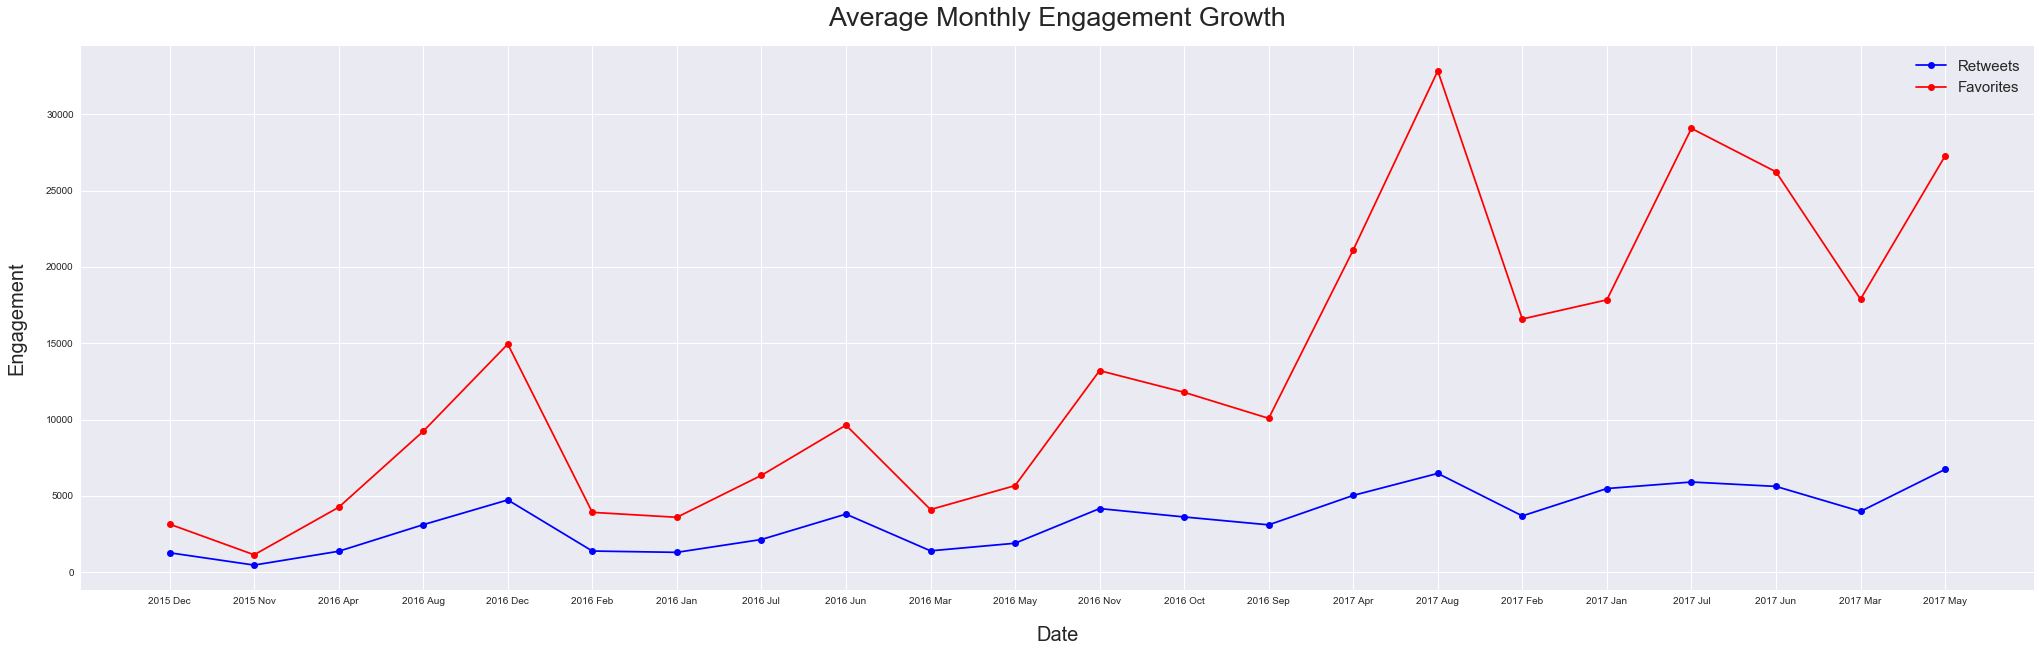

In [114]:
%matplotlib inline
plt.style.use('seaborn')

# Plot engagement factors as y axes
# over the given time period as the x axis
date_x = retweet_averages.index
retweets_y1 = retweet_averages.retweet_count
favorites_y2 = favorite_averages.favorite_count

# Plotting a line plot after changing its width and height 
f = plt.figure() 
f.set_figwidth(35) 
f.set_figheight(10) 
plt.plot(date_x, retweets_y1, label='Retweets', color='b', marker='o')
plt.plot(date_x, favorites_y2, label='Favorites', color='r', marker='o')
# Labelling the plot
plt.xlabel('Date', fontsize=20, labelpad=20)
plt.ylabel('Engagement', fontsize=20, labelpad=20)
plt.title('Average Monthly Engagement Growth', fontsize=27, pad=20)
plt.legend(prop={'size': 15})

# Save the graph and display it
plt.savefig('AvgEngagement.png')
plt.show()

In [60]:
# Get all time retweets and favorites average
print('All time retweets average:', master_df.retweet_count.mean())
print('All time favorites average:',master_df.favorite_count.mean())

All time retweets average:  2385.2576374745418
All time favorites average:  8095.567718940937


#### Insights
We can clearly notice an upward trend in the average monthly engagement measured by retweets and favorites over almost 2 years. This means WeRateDogs fans have been engaging more over this period, maybe even they have been increasing. This growth is an evident indication of the appeal in the content. People clearly enjoy their tweets!

#### 3.1.2. Question (2): Is there any change to the account rating system?
This question is trying to notice if there is any patterns or insights to conclude from the account *special* rating system.

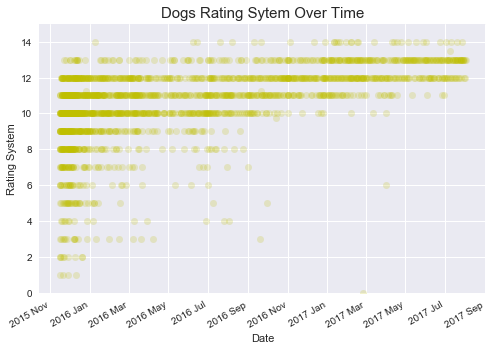

In [120]:
plt.style.use('seaborn')

# Plot rating numerator as the y axis
# and time as the x axis
plt.plot_date(master_df.tweet_timestamp, master_df.rating_numerator, alpha=0.2,  color='y')
plt.gcf().autofmt_xdate()
dates_format = mpl_dates.DateFormatter('%Y %b')
plt.gca().xaxis.set_major_formatter(dates_format)

# with range [0,15] eliminating the inaccurate value of 24
axes = plt.gca()
axes.set_ylim([0,15])

# Set title and labels
plt.title('Dogs Rating Sytem Over Time', fontsize=15)
plt.xlabel('Date')
plt.ylabel('Rating System')

# Save the graph and display it
plt.savefig('RatingGrowth.png')
plt.show()

#### Insights
This is an interesting finding! The account started with normal rating system then they gradually adopted their special rating system, where the numerator is almost always higher than the denominator.

_________________________________________________________________________________________________________________
### 3.2. Dogs Statistics
#### 3.2.1. Question (3): What proportions of *dogs gender* and *dog stage* are there?
This will help us observe the popular gender, as well as stage. These will be kind of fun facts. 

In [149]:
master_df.dog_gender.value_counts()

NaN       1110
male       631
female     223
Name: dog_gender, dtype: int64

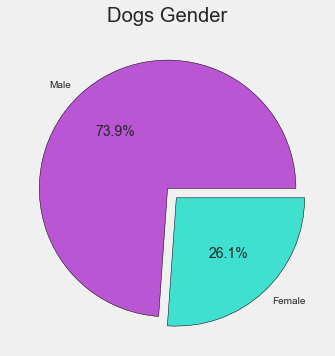

In [193]:
plt.style.use('fivethirtyeight')
# Plot the data by dog gender
gender_sum = master_df.dog_gender.value_counts().male + master_df.dog_gender.value_counts().female
females = master_df.dog_gender.value_counts().female / gender_sum
males = master_df.dog_gender.value_counts().male / gender_sum

slices = [males, females]
labels = ['Male', 'Female']
colors = ['mediumorchid', 'turquoise']
explode = [0, 0.1]

plt.pie(slices, labels=labels, colors=colors, explode=explode, autopct='%1.1f%%',
       wedgeprops={'edgecolor': 'black'})

plt.title('Dogs Gender')

# Save the graph and display it
plt.savefig('DogGender.png')
plt.show()

In [171]:
master_df.dog_stage.value_counts().pupper

201

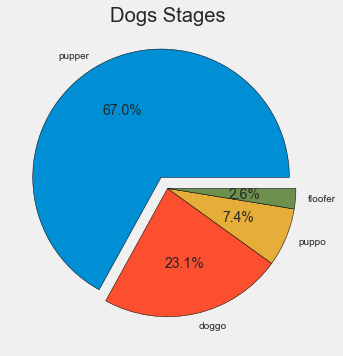

In [194]:
plt.style.use('fivethirtyeight')

# Plot dogs stages according to each count
stage_sum = master_df.dog_stage.value_counts().sum()

puppers = (master_df.dog_stage.value_counts().pupper + 8) / stage_sum
doggos = (master_df.dog_stage.value_counts().doggo + 10) / stage_sum
puppos = (master_df.dog_stage.value_counts().puppo +1) / stage_sum
floofers = (master_df.dog_stage.value_counts().floofer +1) / stage_sum



slices = [puppers, doggos, puppos, floofers]
labels = ['pupper', 'doggo', 'puppo', 'floofer']
explode = [0.1, 0, 0, 0]

plt.pie(slices, labels=labels, explode=explode, autopct='%1.1f%%',
       wedgeprops={'edgecolor': 'black'})

plt.title('Dogs Stages')

# Save the graph and display it
plt.savefig('DogStages.png')
plt.show()


#### Insights
This was definitely fun!
- It's clear that puppers are dominant. By the way, a pupper is *a doggo that is inexperienced, unfamiliar, or unprepared for the responsibilities associated with being a doggo* according to the **Dogtionary** of WeRateDogs book.
- According to what we managed to categorize of dogs genders, males are much higher than female dogs. Nice, huh!

#### 3.2.2. Question (4): What's the percentage of the ML algorithm guessing right (dogs not other objects) from the first trial?
I think answering this question is important, since it will help us observe the used algorithm precision.

In [189]:
first_predictions = image_df[image_df.prediction_level == 1]
first_predictions.if_dog[first_predictions.if_dog==True].count()

True     1463
False     508
Name: if_dog, dtype: int64

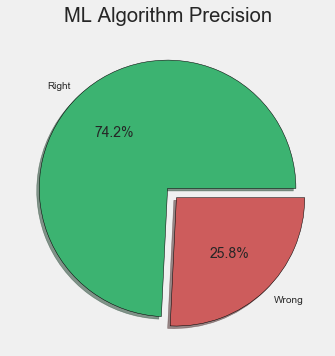

In [195]:
plt.style.use('fivethirtyeight')
# Plot the data according to guessing right and wrong counts
guessings = first_predictions.if_dog.value_counts().sum()

right = first_predictions.if_dog[first_predictions.if_dog==True].count() / guessings
wrong = first_predictions.if_dog[first_predictions.if_dog==False].count() / guessings

slices = [right, wrong]
labels = ['Right', 'Wrong']
colors = ['mediumseagreen', 'indianred']
explode = [0, 0.1]

plt.pie(slices, labels=labels, colors=colors, explode=explode, autopct='%1.1f%%', shadow=True,
       wedgeprops={'edgecolor': 'black'})

plt.title('ML Algorithm Precision')

# Save the graph and display it
plt.savefig('AlgorithmPrecision.png')
plt.show()

#### Insights
The algorithm is actually doing a good job. It predicted from the **first** trial about 74.2% of the images correctly to be dogs and not any other kind of animals or objects. Although the algorithm main goal is to speculate the dog breed, but this is a very important step too. Because in order to guess the breed, it must firstly know for sure that the image is for a dog.

#### 3.2.3. Question (5): Are there some particular popular breeds among WeRateDogs fans?
This question will absolutely be useful to know whether fans prefer certain types of dog breeds. Because if so, the account can raise the engagement by posting photos for these types!

In [206]:
# Create a new dataframe where it combines the first prediction df to the master df
breed_df = pd.merge(master_df, first_predictions, how='left', on='tweet_id')

# Query favorite counts for each breed
breed_df.groupby(['prediction'])['favorite_count'].count()

golden_retriever             137
Labrador_retriever            92
Pembroke                      88
Chihuahua                     78
pug                           54
chow                          41
Samoyed                       39
Pomeranian                    38
toy_poodle                    36
malamute                      29
cocker_spaniel                27
French_bulldog                25
Chesapeake_Bay_retriever      23
seat_belt                     21
miniature_pinscher            21
German_shepherd               20
Siberian_husky                20
Staffordshire_bullterrier     18
Maltese_dog                   18
Shetland_sheepdog             18
Eskimo_dog                    18
beagle                        17
Cardigan                      17
teddy                         17
Shih-Tzu                      17
Italian_greyhound             16
Rottweiler                    16
Lakeland_terrier              15
kuvasz                        15
web_site                      14
          

In [227]:
plt.style.use('seaborn')

# Plot bar chart using the favorite count for breeds query
pop_breeds = breed_df.groupby(['prediction'])['favorite_count'].count()
plt.figure(figsize=(250,50))
pop_breeds.plot.bar()

plt.title('Popular Breeds Among Fans', fontsize=200, pad=80)
plt.xlabel('Breeds', fontsize=150)
plt.ylabel('Favorites', fontsize=150)
plt.xticks(size = 30)


# Save the graph and display it
plt.savefig('PopularBreeds.png')
plt.show()

#### Insights
Despite the viz being unclear in Jupyter notebook, it's very clear in its PNG format. This was very helpful! Now we know the top five most admired dog breeds by WeRateDogs fans are:

- #1 Golden Retriever (duh!)
- #2 Labrador Retriever
- #3 Pembroke
- #4 Chihuahua
- #5 Pug

But we must not conclude this represents a correlation, because the count of these types may just be more as they're very common dog breeds. Nevertheless, it's fun to notice what fans preferred.

__________________________________________________________________________________________________________________
## 3.3. Conclusion

WeRateDogs (@dog_rates) Twitter account data, despite being entertaining, is very useful after analyzing it. The analysis will mainly benefit the account administration, but it's also cool to observe as a dog lover! The following points are the main insights deduced from visualizing their 2015-2017 data:
- 1. The average monthly engagement had an upward trend. The account engagement is certainly growing over years.
- 2. The account started with normal rating system, then they gradually adopted their special rating system, where the numerator is almost always higher than the denominator.
- 3. Puppers are the most common stage for dogs.
- 4. Male dogs are much higher than female dogs.
- 5. The used ML algorithm guessed the photo content as a dog from the first trial about 74.2% of the whole guesses. Nice!
- 6. The top five most admired dog breeds by WeRateDogs fans are:

    - #1 Golden Retriever (duh!)
    - #2 Labrador Retriever
    - #3 Pembroke
    - #4 Chihuahua
    - #5 Pug

This was fun. You yourself can try and send your dog image to WeRateDogs and check her/his rating!
